In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path+"/"+"train")

    train_datagen = ImageDataGenerator()

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path+"/"+"train",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    valid_datagen = ImageDataGenerator()
    validation_generator = valid_datagen.flow_from_directory(
        base_path+"/"+"val",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',shuffle=False)
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_directory(
        base_path+"/"+"test",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', shuffle=False)
    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator,test_generator

In [3]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [4]:
def initiateVGG19(noOfClasses):
    modelInput = tf.keras.applications.VGG19(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [5]:
def initiateDenseNet201(noOfClasses):
    modelInput = tf.keras.applications.DenseNet201(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model


In [6]:
def initiateMobileNetV3(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

In [7]:
def initiateParams(className, model, lr,model_name):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + model_name+'.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint

In [8]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history


In [9]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [10]:
def evalModel(model):
    evl = model.evaluate(test_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    return acc
    
def saveModel(model, className,model_name):
    model.save(className + " - "+model_name+"Final.h5")
    print("Model Saved!")

In [11]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [12]:
from sklearn.metrics import recall_score,precision_score,f1_score
def callPlot(model, className, classes):
    y_true = test_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))
    
    conf_mat = confusion_matrix(y_true, y_pred)
    acc=np.trace(conf_mat) / float(np.sum(conf_mat))
    print(f"ACCURACY={acc}")
    recall=recall_score(y_true,y_pred,average='weighted')
    p=precision_score(y_true, y_pred,average='weighted')
    f1=f1_score(y_true, y_pred,average='weighted')
   
    print(f"RECALL={recall}")
    print(f"precision={p}")
    print(f"F1 Score{f1}")
    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [13]:
mpath = r'../input/multi-cancer/Dataset'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 20
lr = 0.001

In [14]:
import pprint
part={}
for c in classPaths:
#     part[c]={'models':{"EfficientNetB7":{"model":None,"accurary":0},
#                     "Densenet201":{"model":None,"accurary":0},
#                     "VGG19":{"model":None,"accurary":0},
#                     "ResnetV2":{"model":None,"accurary":0},
#                     "mobilenetV3":{"model":None,"accurary":0}
#                    },'no_of_classes':0,"ClassNames":None}
    part[c]={'models':{},'no_of_classes':0,"ClassNames":None}

In [15]:
pprint.pprint(part)

{'ALL': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Brain Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Breast Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Cervical Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Kidney Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Lung and Colon Cancer': {'ClassNames': None,
                           'models': {},
                           'no_of_classes': 0},
 'Lymphoma': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Oral Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0}}


In [16]:
def Ensemble(c):
    y_true = test_generator.classes
    print("True : ", (y_true))
    pred=[]
    for model,obj in part[c]['models'].items():
        pred.append(obj['model'].predict(test_generator)*obj['Accurary'])
    y_pred=pred[0]
    for i in range(1,len(pred)):
        y_pred=y_pred+pred[i]
        
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)
    acc=np.trace(conf_mat) / float(np.sum(conf_mat))
    print(f"ACCURACY={acc}")
    recall=recall_score(y_true,y_pred,average='weighted')
    p=precision_score(y_true, y_pred,average='weighted')
    f1=f1_score(y_true, y_pred,average='weighted')
    print(f"RECALL={recall}")
    print(f"precision={p}")
    print(f"F1 Score{f1}")

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = part[c]['ClassNames'],
                          title        = c + "Confusion Matrix")

In [17]:
def initiateResNet50V2(noOfClasses):
    modelInput = tf.keras.applications.ResNet50V2(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

In [18]:
for c in classPaths:
    print(c)

Cervical Cancer
Lung and Colon Cancer
Oral Cancer
ALL
Kidney Cancer
Breast Cancer
Lymphoma
Brain Cancer



Total :  Found 17500 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Val :  Found 3750 images belonging to 5 classes.
Found 3750 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
######################################################
RESULTS FORVGG-19
80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/20
547/547 [==============================] - ETA: 0s - loss: 1.5731 - accuracy: 0.9183
Epoch 1: val_loss improved from inf to 0.73748, saving model to Cervical CancerVGG-19.h5
547/547 [==============================] - 192s 330ms/step - loss: 1.5731 - accuracy: 0.9183 - val_loss: 0.7375 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 2/20
547/547 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.9795
Epoch 2: val_loss improved from 0.73748 to 0.70211, saving model to Cervical CancerVGG-19.

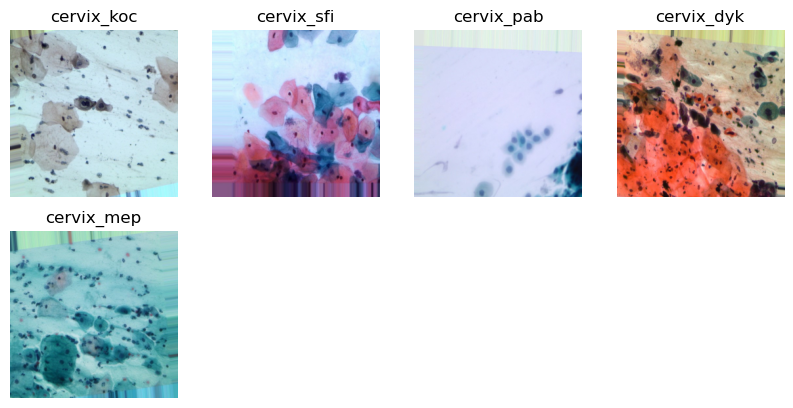

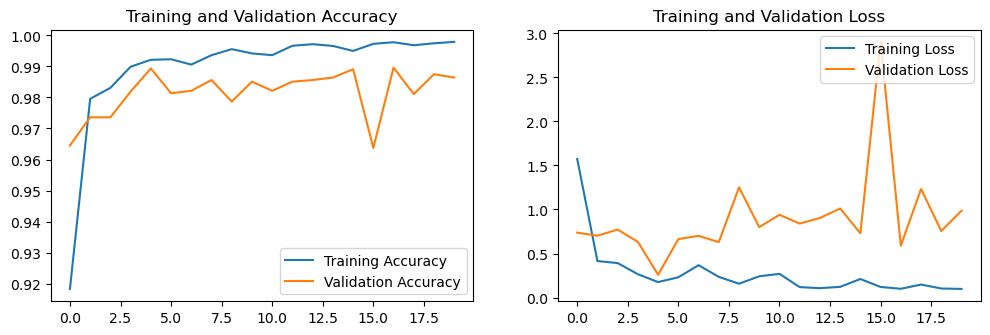

118/118 [==============================] - 34s 285ms/step - loss: 0.6720 - accuracy: 0.9891
Accuracy on the Test Set = 98.91 %
Model Saved!
True :  [0 0 0 ... 4 4 4]
118/118 [==============================] - 19s 161ms/step
Predicted :  [0 0 0 ... 4 4 4]
ACCURACY=0.9890666666666666
RECALL=0.9890666666666666
precision=0.9891694364407169
F1 Score0.9890777752461215


<Figure size 640x480 with 0 Axes>

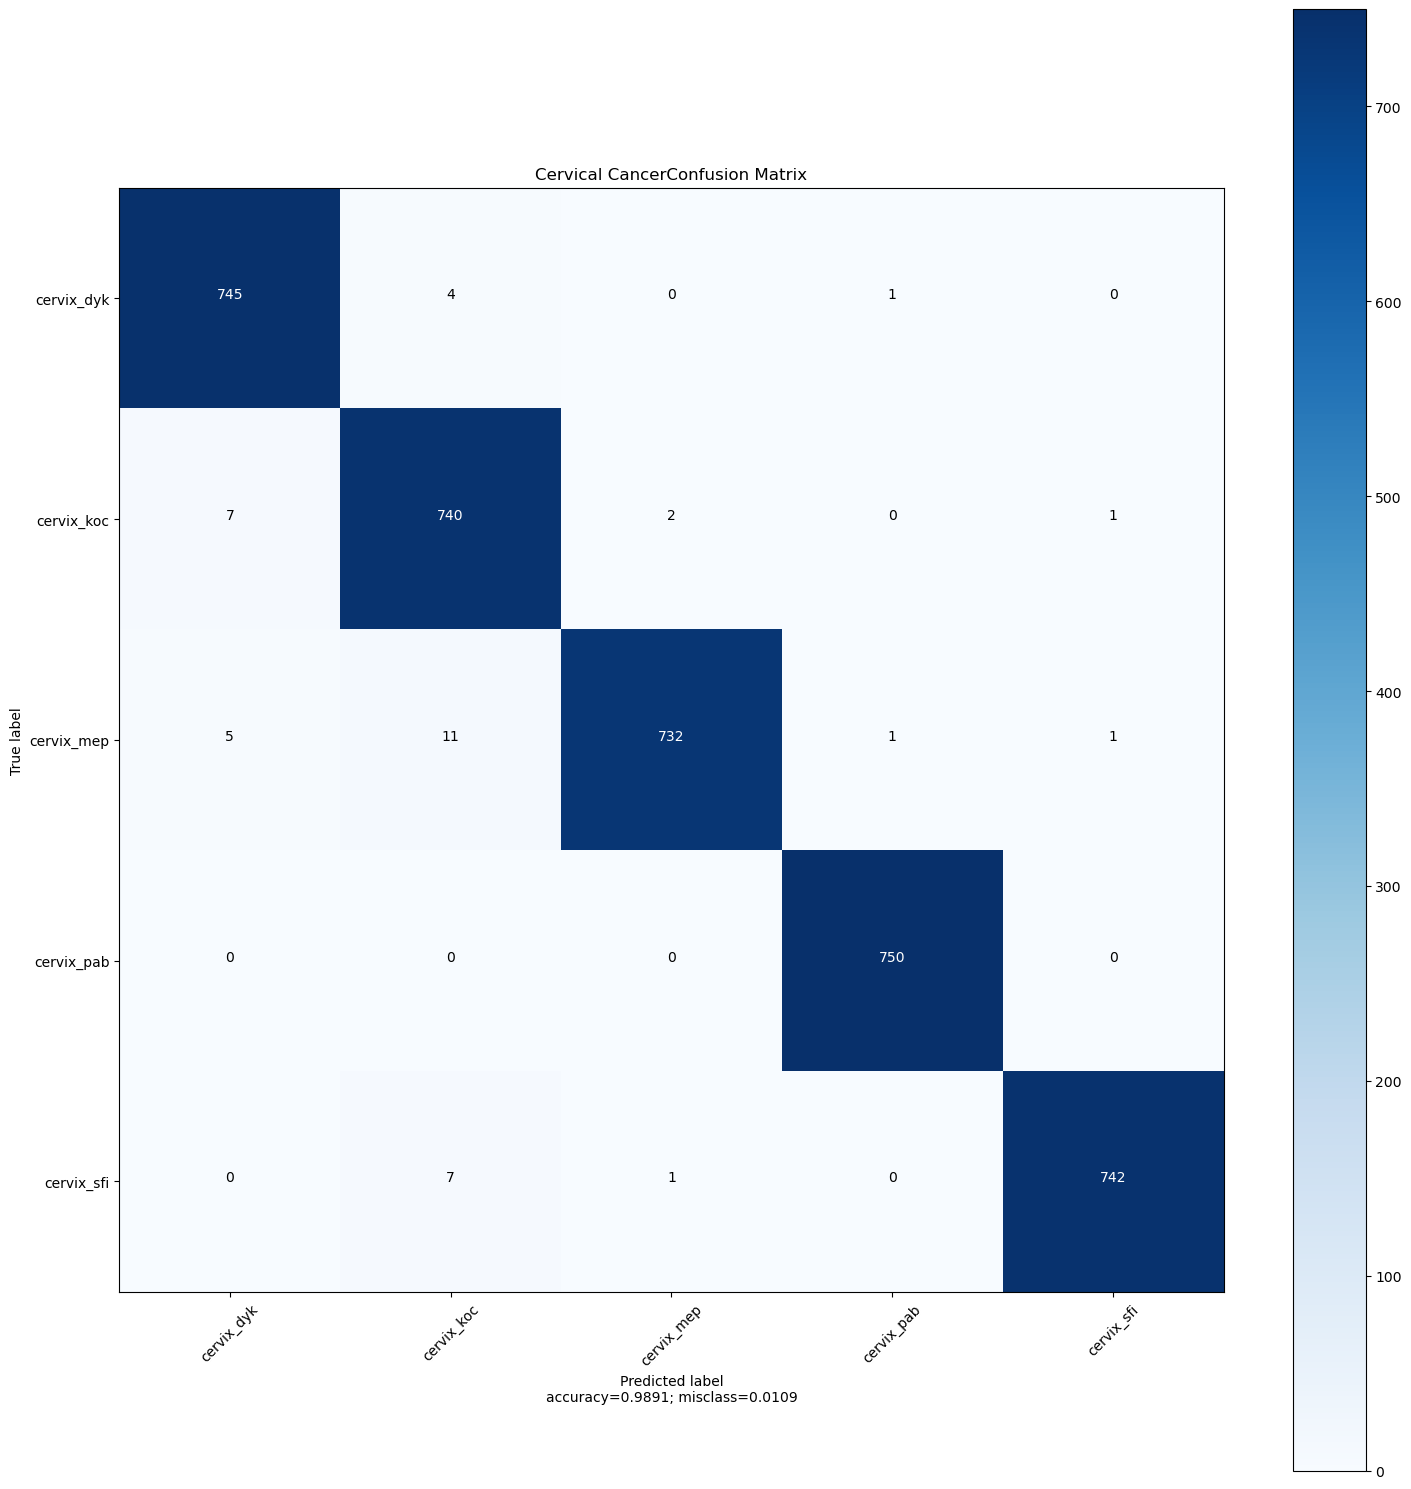

######################################################
RESULTS FORDenseNet201
74836368/74836368 [==============================] - 0s 0us/step
Epoch 1/20
547/547 [==============================] - ETA: 0s - loss: 3.2056 - accuracy: 0.8815
Epoch 1: val_loss improved from inf to 5.75796, saving model to Cervical CancerDenseNet201.h5
547/547 [==============================] - 121s 197ms/step - loss: 3.2056 - accuracy: 0.8815 - val_loss: 5.7580 - val_accuracy: 0.8581 - lr: 0.0010
Epoch 2/20
547/547 [==============================] - ETA: 0s - loss: 1.6856 - accuracy: 0.9507
Epoch 2: val_loss improved from 5.75796 to 1.88408, saving model to Cervical CancerDenseNet201.h5
547/547 [==============================] - 98s 179ms/step - loss: 1.6856 - accuracy: 0.9507 - val_loss: 1.8841 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 3/20
547/547 [==============================] - ETA: 0s - loss: 0.7976 - accuracy: 0.9743
Epoch 3: val_loss improved from 1.88408 to 0.69061, saving model to Cervical Cance

<Figure size 640x480 with 0 Axes>

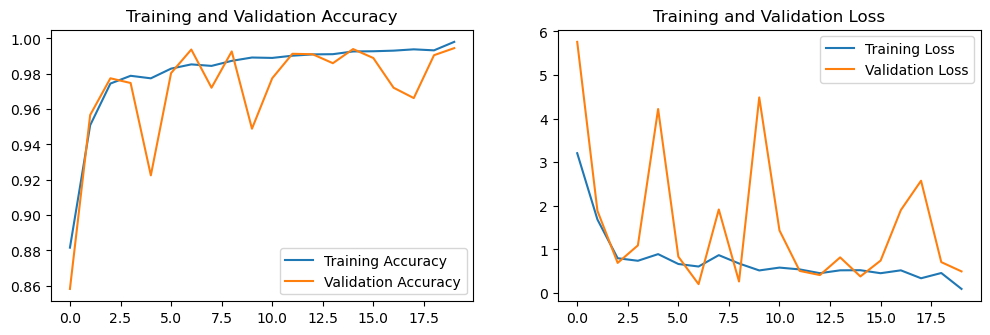

118/118 [==============================] - 17s 146ms/step - loss: 0.3649 - accuracy: 0.9944
Accuracy on the Test Set = 99.44 %
Model Saved!
True :  [0 0 0 ... 4 4 4]
118/118 [==============================] - 20s 139ms/step
Predicted :  [0 0 0 ... 4 4 4]
ACCURACY=0.9944
RECALL=0.9944
precision=0.994463029969946
F1 Score0.9944038407241459


<Figure size 640x480 with 0 Axes>

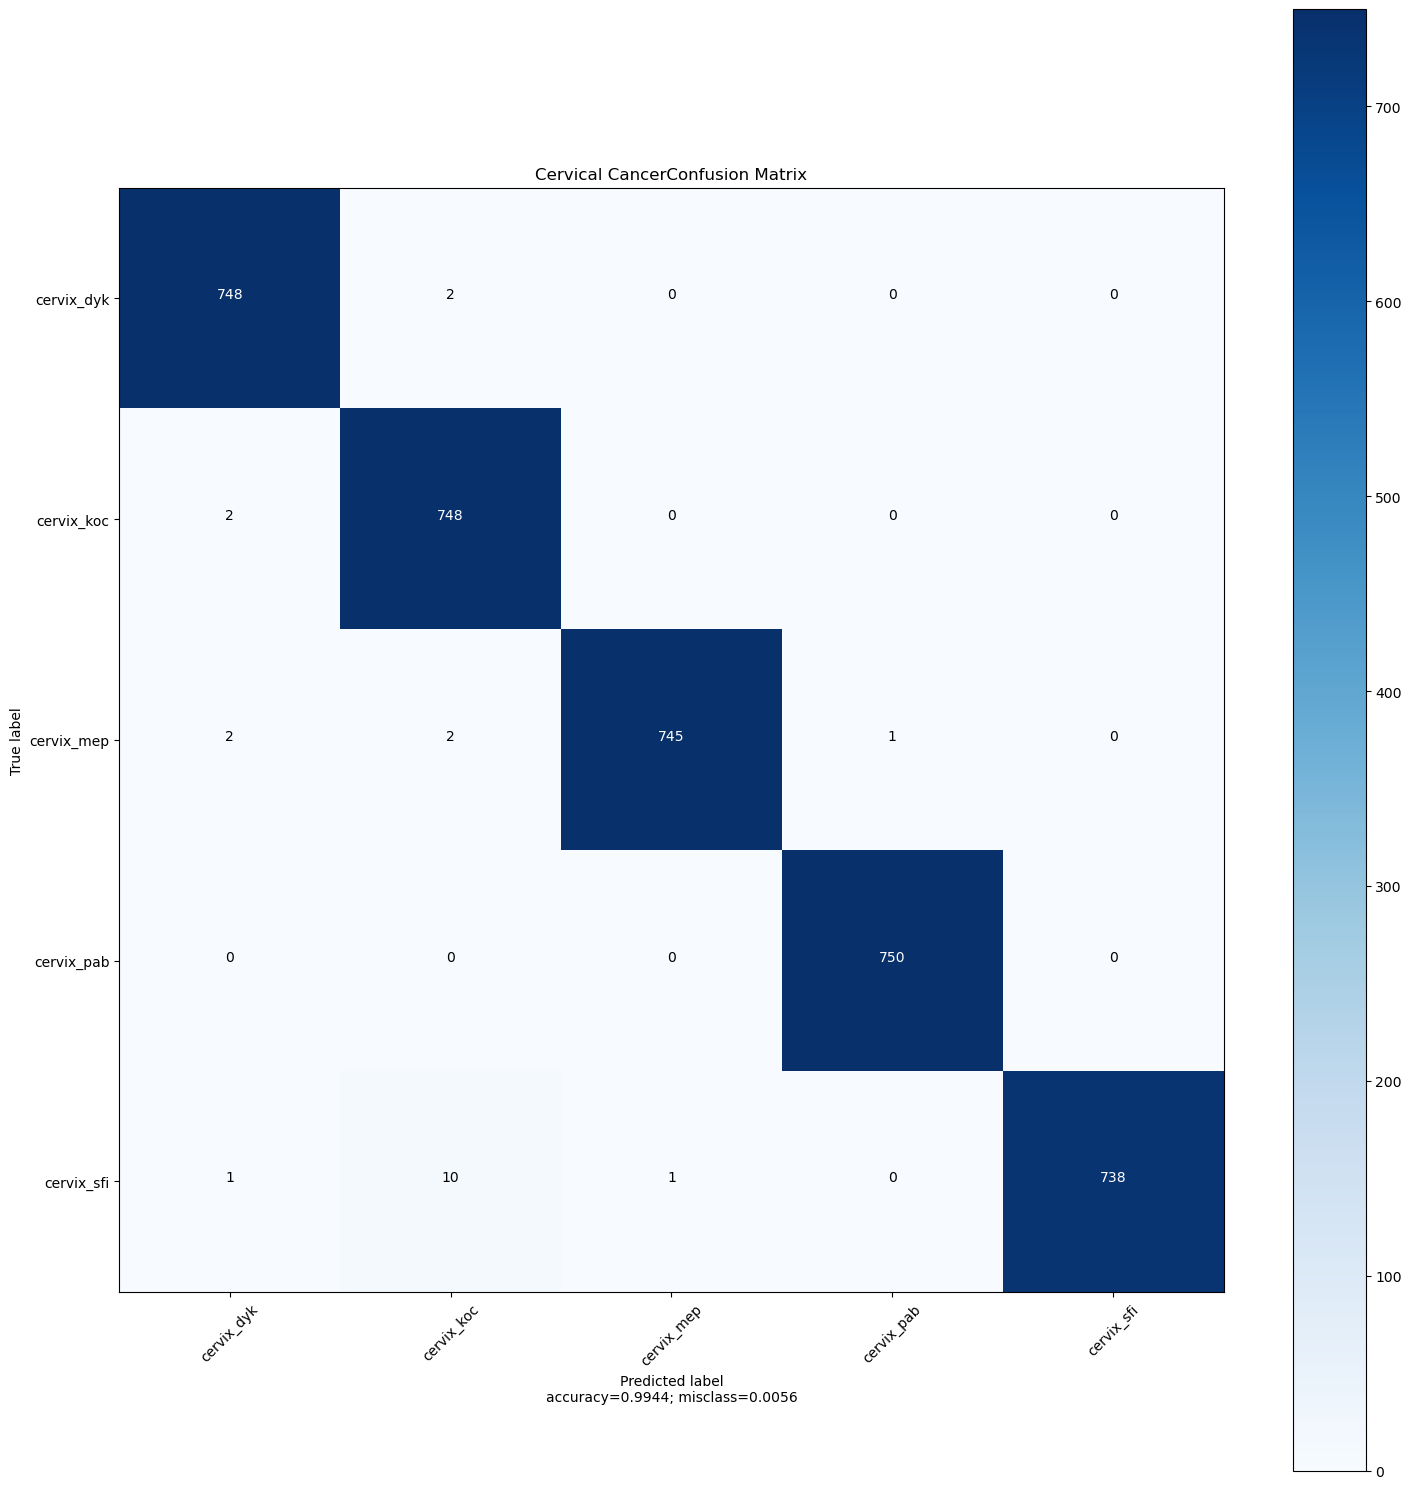

######################################################
RESULTS FORMobileNetV3
4334752/4334752 [==============================] - 0s 0us/step
Epoch 1/20
547/547 [==============================] - ETA: 0s - loss: 0.4943 - accuracy: 0.9119
Epoch 1: val_loss improved from inf to 0.21332, saving model to Cervical CancerMobileNetV3.h5
547/547 [==============================] - 70s 121ms/step - loss: 0.4943 - accuracy: 0.9119 - val_loss: 0.2133 - val_accuracy: 0.9632 - lr: 0.0010
Epoch 2/20
547/547 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.9791
Epoch 2: val_loss improved from 0.21332 to 0.21049, saving model to Cervical CancerMobileNetV3.h5
547/547 [==============================] - 65s 119ms/step - loss: 0.1168 - accuracy: 0.9791 - val_loss: 0.2105 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 3/20
547/547 [==============================] - ETA: 0s - loss: 0.1060 - accuracy: 0.9836
Epoch 3: val_loss did not improve from 0.21049
547/547 [=============================

<Figure size 640x480 with 0 Axes>

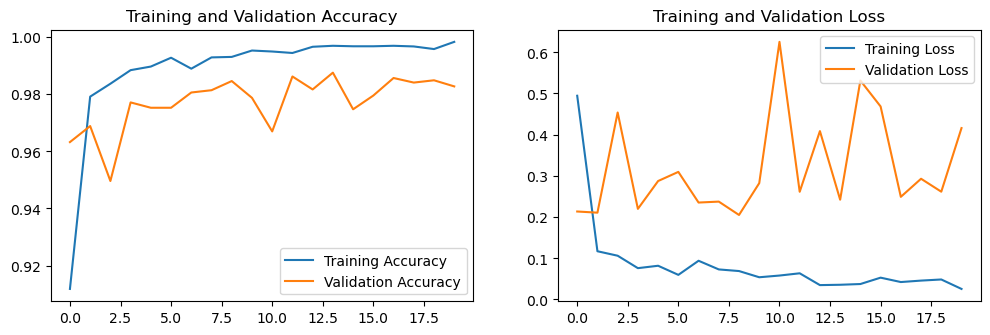

118/118 [==============================] - 14s 118ms/step - loss: 0.4016 - accuracy: 0.9827
Accuracy on the Test Set = 98.27 %
Model Saved!
True :  [0 0 0 ... 4 4 4]
118/118 [==============================] - 12s 94ms/step
Predicted :  [0 0 0 ... 4 4 4]
ACCURACY=0.9826666666666667
RECALL=0.9826666666666667
precision=0.9829379948701118
F1 Score0.9826295355747524


<Figure size 640x480 with 0 Axes>

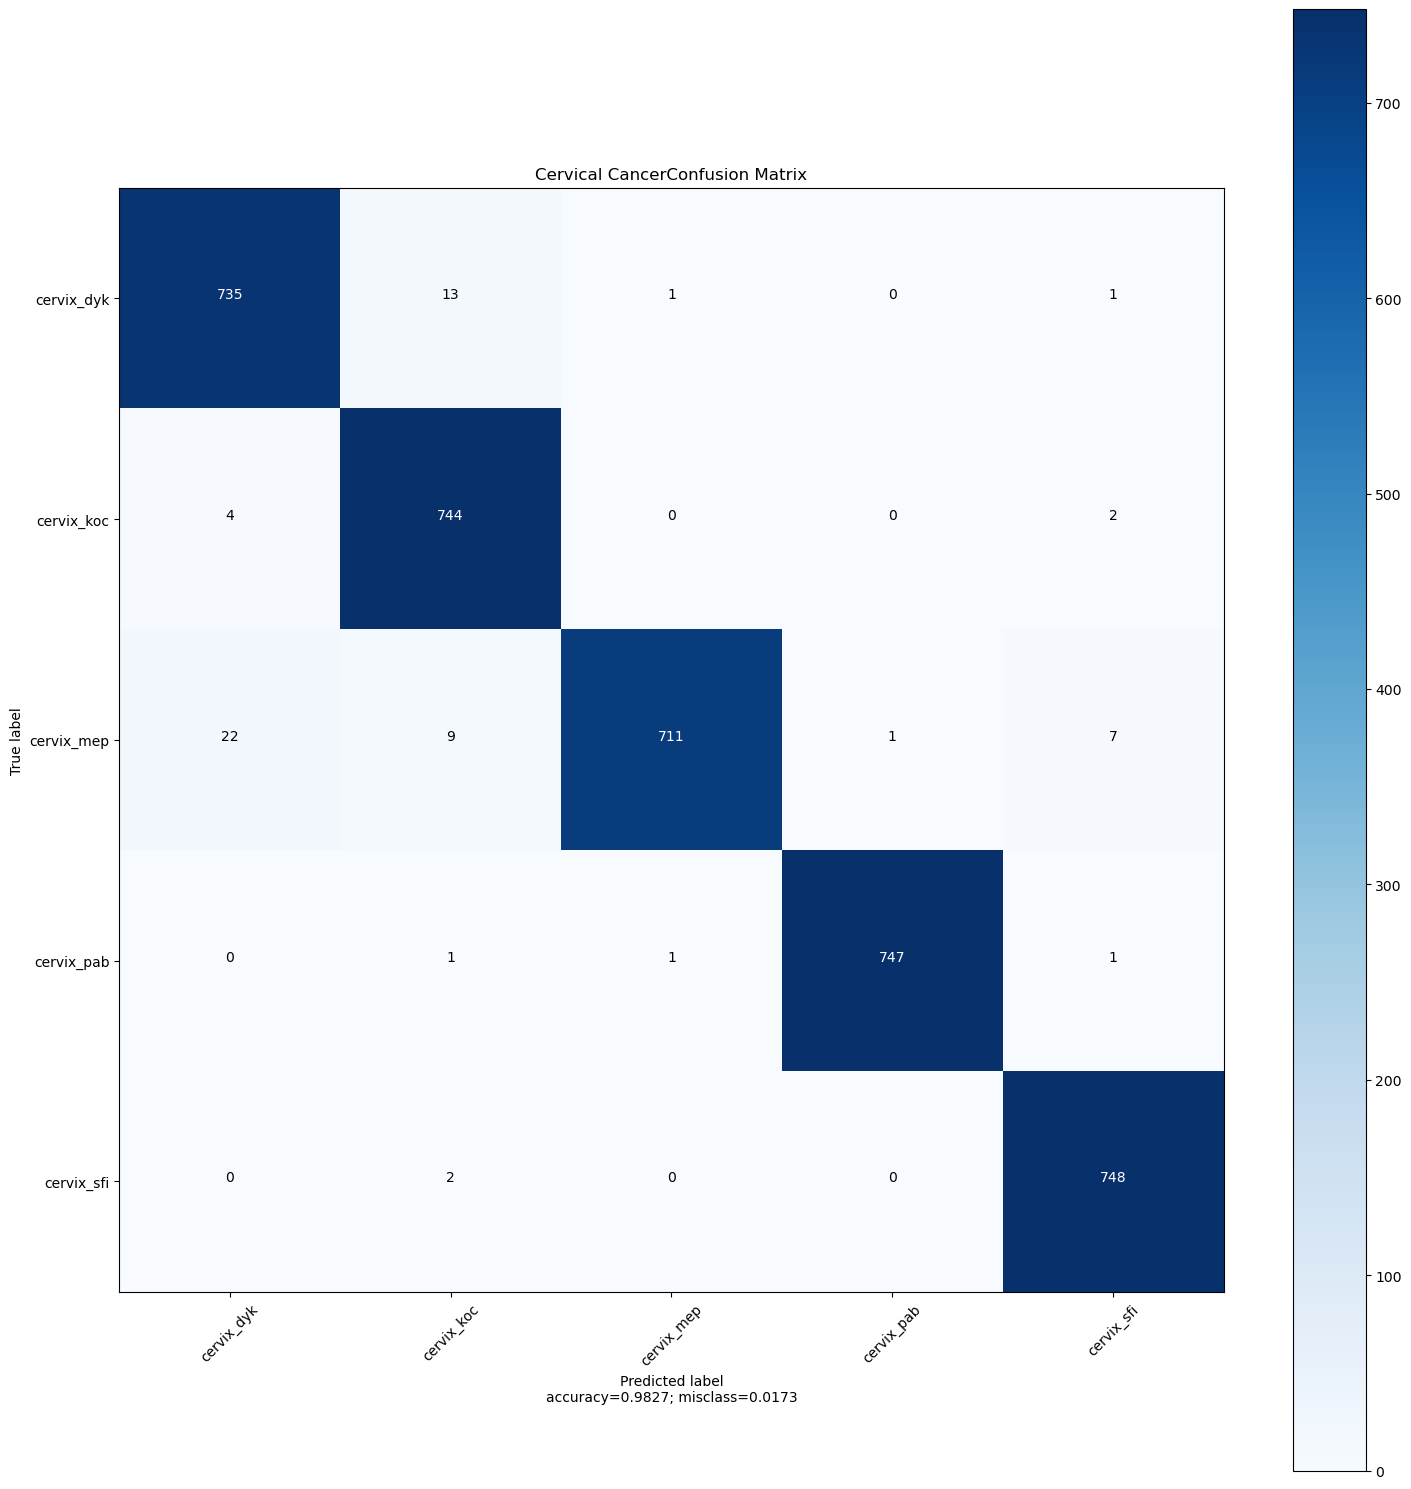

######################################################
RESULTS FORResNet50V2
94668760/94668760 [==============================] - 1s 0us/step
Epoch 1/20
547/547 [==============================] - ETA: 0s - loss: 237.8639 - accuracy: 0.6287
Epoch 1: val_loss improved from inf to 73.47887, saving model to Cervical CancerResNet50V2.h5
547/547 [==============================] - 81s 140ms/step - loss: 237.8639 - accuracy: 0.6287 - val_loss: 73.4789 - val_accuracy: 0.7808 - lr: 0.0010
Epoch 2/20
547/547 [==============================] - ETA: 0s - loss: 112.4643 - accuracy: 0.7647
Epoch 2: val_loss did not improve from 73.47887
547/547 [==============================] - 74s 135ms/step - loss: 112.4643 - accuracy: 0.7647 - val_loss: 134.2825 - val_accuracy: 0.7485 - lr: 0.0010
Epoch 3/20
547/547 [==============================] - ETA: 0s - loss: 109.8624 - accuracy: 0.7941
Epoch 3: val_loss improved from 73.47887 to 52.33035, saving model to Cervical CancerResNet50V2.h5
547/547 [=============

<Figure size 640x480 with 0 Axes>

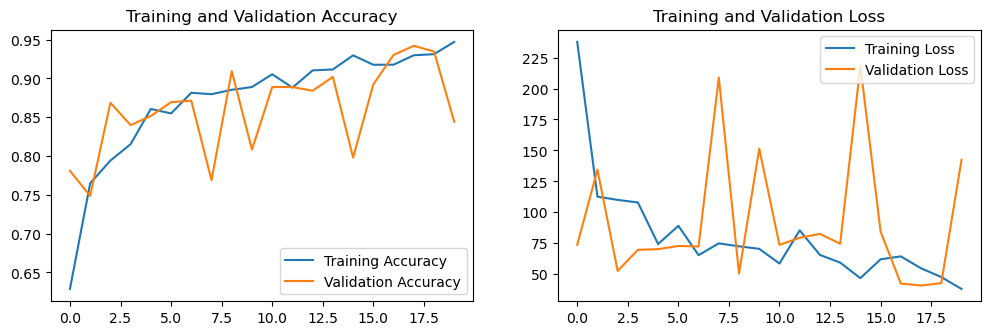

118/118 [==============================] - 16s 132ms/step - loss: 136.2371 - accuracy: 0.8512
Accuracy on the Test Set = 85.12 %
Model Saved!
True :  [0 0 0 ... 4 4 4]
118/118 [==============================] - 13s 102ms/step
Predicted :  [0 0 3 ... 4 0 3]
ACCURACY=0.8512
RECALL=0.8512
precision=0.881911965145657
F1 Score0.847642216679388


<Figure size 640x480 with 0 Axes>

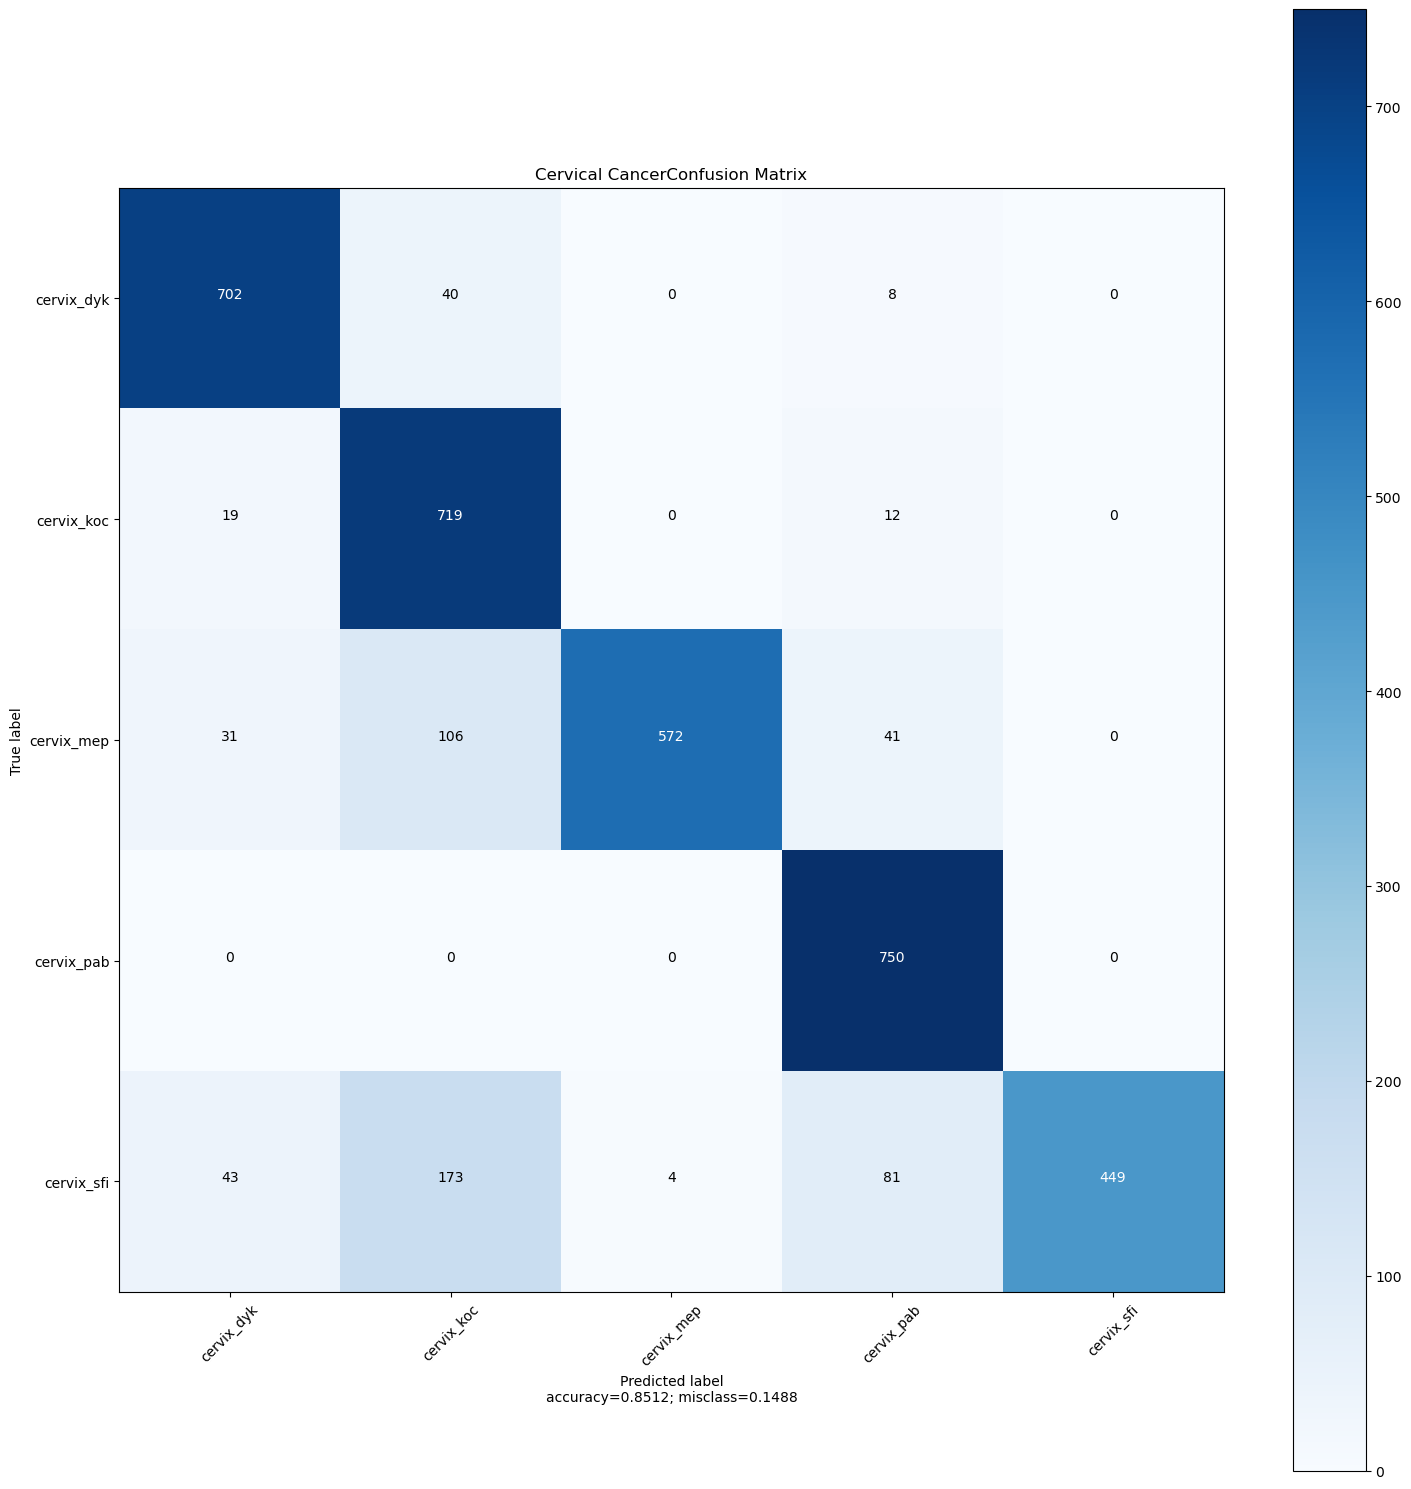

######################################################
RESULTS FOR ENSEMBLE
True :  [0 0 0 ... 4 4 4]
118/118 [==============================] - 13s 106ms/step
Predicted :  [0 0 0 ... 4 4 4]
ACCURACY=0.9981333333333333
RECALL=0.9981333333333333
precision=0.9981358160750206
F1 Score0.9981333307240217


<Figure size 640x480 with 0 Axes>

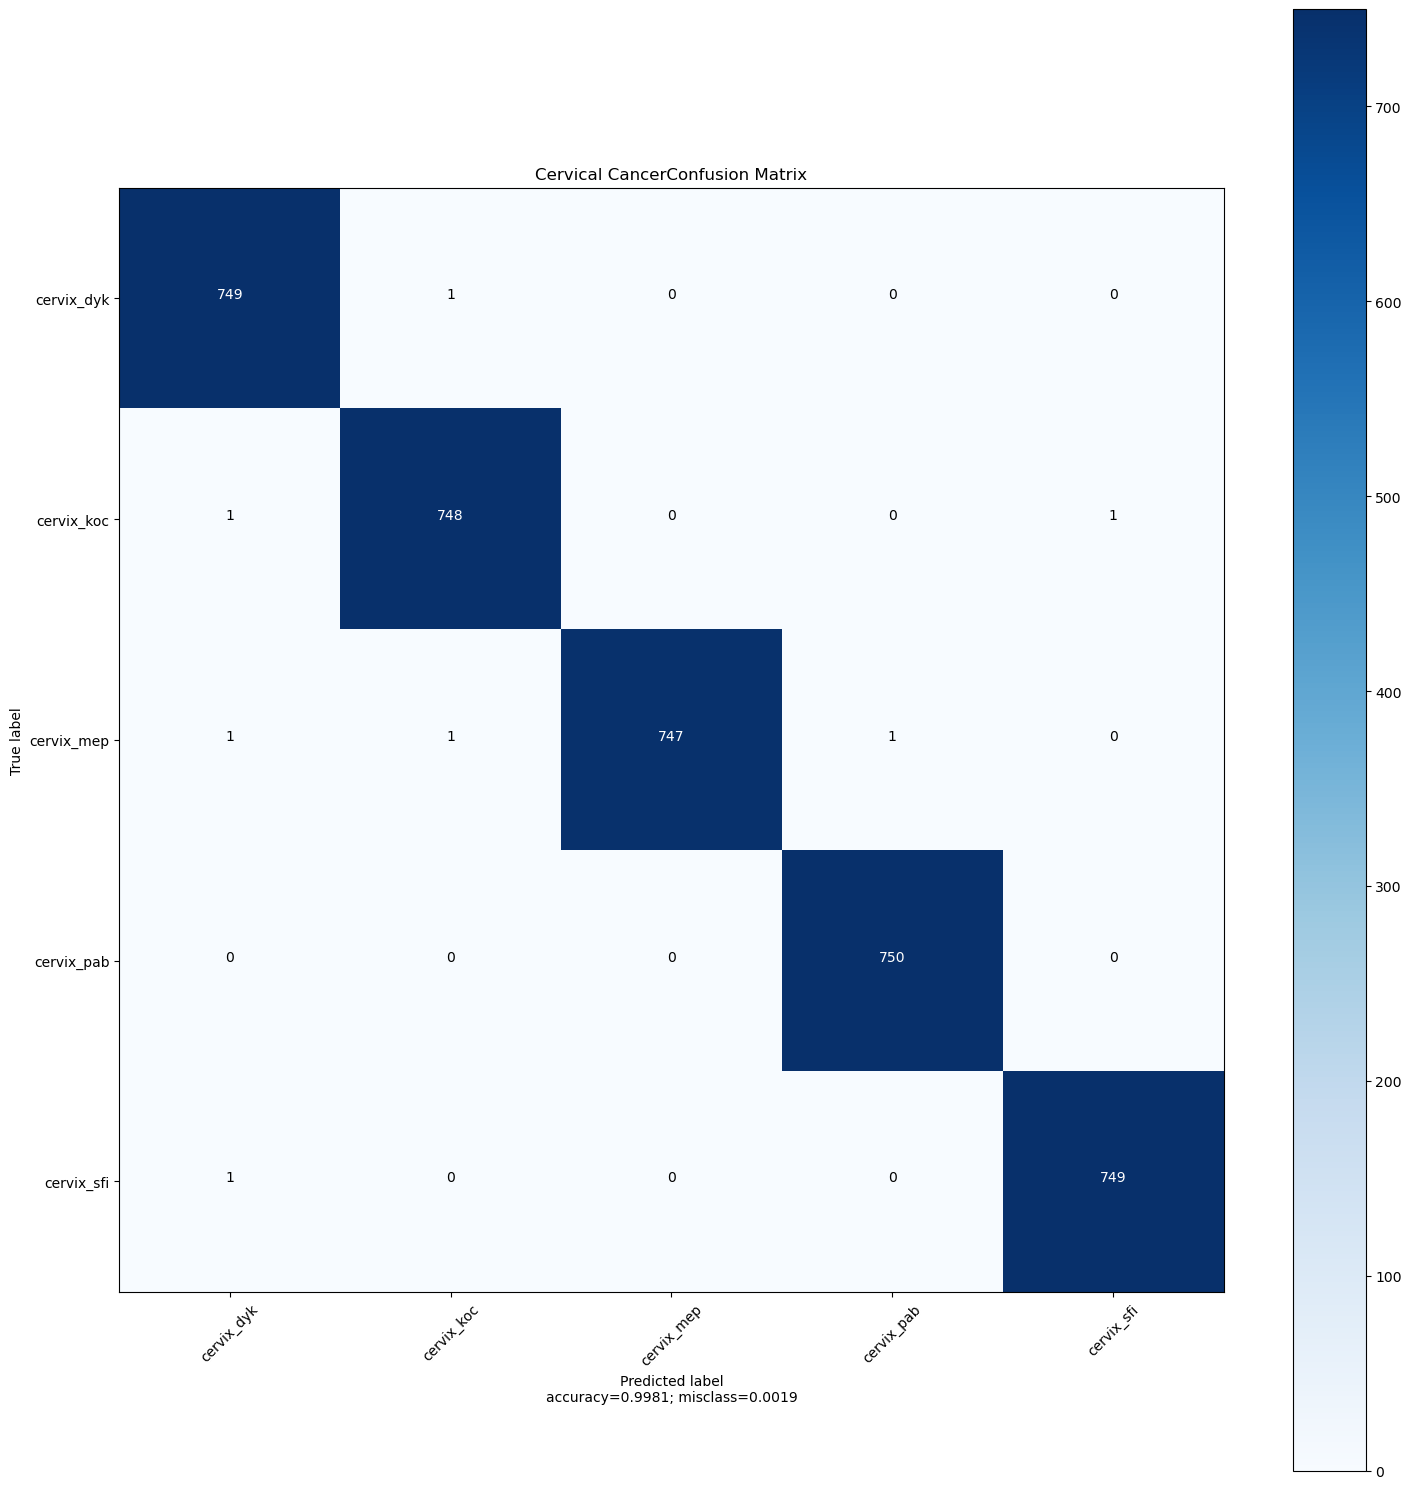

<Figure size 640x480 with 0 Axes>

In [19]:
for c in classPaths[0:1]:
    className = c
#     model_name="VGG-19"
    cpath = os.path.join(mpath, c)
    noOfClasses, class_names, train_generator, validation_generator,test_generator = initiateGenerator(cpath)
    part[c]['ClassNames']=class_names
    
    
    
    model_name="VGG-19"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curVGG19 = initiateVGG19(noOfClasses)
    #modelSummary(curVGG19)
    curVGG19, annealer, checkpoint = initiateParams(className, curVGG19, lr,model_name)
    curHistory = modelFit(curVGG19, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curVGG19)
    
    saveModel(curVGG19, className,model_name)
    part[c]['models']['VGG19']={"model":curVGG19,'Accurary':acc}
    callPlot(curVGG19, className, class_names)
    
    model_name="DenseNet201"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curDenseNet201= initiateDenseNet201(noOfClasses)
    #modelSummary(curDenseNet201)
    curDenseNet201, annealer, checkpoint = initiateParams(className, curDenseNet201, lr,model_name)
    curHistory = modelFit(curDenseNet201, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curDenseNet201)
    saveModel(curDenseNet201, className,model_name)
    part[c]['models']['DenseNet201']={"model":curDenseNet201,'Accurary':acc}
    callPlot(curDenseNet201, className, class_names)
    
    
    
    model_name="MobileNetV3"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curMobileNetV3 = initiateMobileNetV3(noOfClasses)
    #modelSummary(curMobileNetV3)
    curMobileNetV3, annealer, checkpoint = initiateParams(className, curMobileNetV3, lr,model_name)
    curHistory = modelFit(curMobileNetV3, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curMobileNetV3)
    saveModel(curMobileNetV3, className,model_name)
    part[c]['models']['MobileNetV3']={"model":curMobileNetV3,'Accurary':acc}
    callPlot(curMobileNetV3, className, class_names)
    
    model_name="ResNet50V2"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curResNet50V2 = initiateResNet50V2(noOfClasses)
    #modelSummary(curResNet50V2)
    curResNet50V2, annealer, checkpoint = initiateParams(className, curResNet50V2, lr,model_name)
    curHistory = modelFit(curResNet50V2, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curResNet50V2)
    saveModel(curResNet50V2, className,model_name)
    part[c]['models']['ResNet50V2']={"model":curResNet50V2,'Accurary':acc}
    callPlot(curResNet50V2, className, class_names)
    print("######################################################")
    print(f"RESULTS FOR ENSEMBLE")
    Ensemble(c)
    
    
    